# sleep_node_random

スリープノードを固定して経路群を構築

書き出したデータは./random/に保存される

In [27]:
from itertools import combinations
import json
import os
from glob import glob
from collections import defaultdict
import random
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
from graphillion import GraphSet

from proposal_packages.gridgraph import GridGraph

%matplotlib inline

In [28]:
# 必要な関数

project_dir = "./random/"

def get_min_hop_num(terminal):
    """
    ある2点間のパスの最小ホップ数を求める
    重み付きグラフやメトリックテーブルを与えないでmin_iterを使用すると
    最小ホップ数のサブグラフからイテレートすることを利用する
    
    arguments:
    * terminal(tuple)
       端点を表す(s, t)形式のタプル
    """
    return len(next(GraphSet.paths(terminal[0], terminal[1]).min_iter()))

def get_min_hop_paths(paths, terminal):
    min_hop = get_min_hop_num(terminal)
    return paths.graph_size(min_hop)

def get_paths_removed_nodes(paths, nodes):
    for node in nodes:
        paths = paths.excluding(node)
    return paths
    
def flatten_paths(paths):
    """
    パス集合を平滑化して、リンクを要素とするリストを返す
    """
    return [edge for path in paths for edge in path]

def select_sleep_nodes(grid_graph, terminal, num):
    """
    ある確率でスリープ状態になるノードを選択する
    """
    nodes = set(grid_graph.nx_graph.nodes()) - set(terminal)
    return random.sample(nodes, k=num)

def create_minhop_path(paths, nodes):
    for node in nodes:
        paths = paths.including(node)
    return paths.choice()

def hamming(graphset, G, upper_limit):
    L = []
    lower_limit = 0
    for e in graphset:
        # 重み付きリンクとして定義されているとき，辺を表すタプルは(i,j,w)と表される．
        # そこからi,jのみ取り出すためe[:2]としている
        e = e[:2]
        if e in G:
            L.append((e[0], e[1], -1))
            lower_limit -= 1
        elif (e[1], e[0]) in G:
            L.append((e[1], e[0], -1))
            lower_limit -= 1
        else:
            L.append((e[0], e[1], 1))

    # print((L, (lower_limit, lower_limit + upper_limit)))
    # print("L=", L, "lower_limit=", lower_limit, "lower_limit+upper_limit=", lower_limit + upper_limit)
    return GraphSet.graphs(linear_constraints=[(L, (lower_limit, lower_limit + upper_limit))])

def get_similar_paths(edgelist, terminal, path, upper_limit):
    """
    arguments:
    * edgelist
    * terminal(tuple)
      (start, target)を表すタプル
    * path
    * upper_limit
    """
    if path is None:
        return
    similar_graphset = hamming(edgelist, path, upper_limit)
    similar_paths = GraphSet.paths(terminal[0], terminal[1], graphset=similar_graphset)
    return similar_paths

def draw_candidates5(candidates, pathset_nodes):
    """
    とりあえず5本描画する用の設定
    """
    plt.figure(figsize=(n+n*2+60, n+n*2+60))
    for i,  path in enumerate(candidates):
        plt.subplot(11, 10, 1+i)
        grid_graph.draw(subgraph=path, optional_colored_nodes=pathset_nodes)

def hamming_between_candidates(paths):
    res = defaultdict(list)
    for _path1, _path2 in combinations(paths, 2):
        duplicate_link_num = len(set(_path1) - set(_path2))
        res[tuple(_path1)].append(duplicate_link_num)
        res[tuple(_path2)].append(duplicate_link_num)
    
    total = 0
    for path, l in res.items():
        if sum(l) > total:
            total = sum(l)
            determinated = path
    return determinated, res

def select_sleep_nodes_every_time(graph, terminal, sleep_num, times):
    
    """
    毎回，スリープノードを選択して，そのノードセットを格納したリストを返す
    
    arguments:
    * graph
    * terminal(tuple)
       スタートとターゲットを指定
    * sleep_num(int)
       スリープするノード数
    * times(int)
       構築する経路群の本数
    
    returns:
    * sleep_nodes_sleep(list)
       スリープノードを格納したリスト
    """
    sleep_nodes_set = []
    for _ in range(times):
        sleep_nodes_set.append(select_sleep_nodes(grid_graph, terminal, sleep_num))
    return sleep_nodes_set

def create_candidate_paths(paths, sleep_nodes_set, terminal):
    """
    経路群を構築し，キーがスリープノード．値がパスの辞書を返す
    TODO: 経路を構築できなかったときの例外処理が必要
    
    arguments:
    * paths(GraphSet object)
    * sleep_nodes_set(list)
       select_sleep_nodes_every_timeが返すリスト
    * terminal(tuple)
       スタートとターゲットを指定
    """
    candidates = {}
    minhop_paths = get_min_hop_paths(paths, terminal)
    for nodes in sleep_nodes_set:
        paths_excluded_sleep_nodes = minhop_paths.copy()
        for node in nodes:
            paths_excluded_sleep_nodes = paths_excluded_sleep_nodes.excluding(node)
            try:
                choiced = paths_excluded_sleep_nodes.choice()
                candidates[tuple(nodes)] = choiced
            except KeyError:
                candidates[tuple(nodes)] = None
    return candidates

def _project_exists():
    """
    ランダム選択の結果のjsonファイルを
    保存するディレクトリが存在するか確認する
    """
    if not os.path.exists(project_dir):
        os.mkdir(project_dir)

def _create_sequencial_filename(candidates):
    """
    ファイル名が重複しないように
    ファイル名末尾に通し番号を付ける
    """
    keys = list(candidates.keys())
    filename = "sleep{}_candidate{}*.json".format(len(keys[0]), len(keys))
    sequencial_file_numbers = []
    for matched in glob(project_dir + filename):
        matched = os.path.splitext(os.path.basename(matched))[0]
        sequencial_file_numbers.append(int(matched.split("_")[2]))
    if sequencial_file_numbers:
        next_num = max(sequencial_file_numbers) + 1
    else:
        next_num = 1
    if all(candidates.values()):
        return "sleep{}_candidate{}_{}.json".format(len(keys[0]), len(keys), next_num)
    else:
        return "sleep{}_candidate{}_{}_failure.json".format(len(keys[0]), len(keys), next_num)

def dump_candidate_json(candidates):
    """
    candidatesをjsonファイルにして書き出す
    
    書き出すjsonファイルの命名規則について
    sleep{sleep node num}_candidate{candidate path num}_{sequencial}.json
    """
    _project_exists()
    filename = _create_sequencial_filename(candidates)
    with open(project_dir + filename, "w") as result_json:
        result_json.write(json.dumps({str(k): v for k, v in candidates.items()}))

def load_candidate_json(filename):
    """
    candidatesの内容を書き出したjsonファイルを読み込んで辞書形式に復元する
    """
    str2tuple = lambda s: tuple(map(int, s[1:-1].split(",")))
    candidates = {}
    with open(project_dir + filename, "r") as f:
        temp_candidates = json.load(f)
        for nodes, path in temp_candidates.items():
            if path is None:
                candidates[str2tuple(nodes)] = None
            else:
                candidates[str2tuple(nodes)] = list(map(tuple, path))
    return candidates

def draw_candidates5(candidates):
    """
    とりあえず5本描画する用の設定
    """
    plt.figure(figsize=(n+n*2+60, n+n*2+60))
    for i, (nodes, path) in enumerate(candidates.items()):
        plt.subplot(11, 10, 1+i)
        if path is not None:
            grid_graph.draw(subgraph=path, optional_colored_nodes=nodes)
        else:
            grid_graph.draw(optional_colored_nodes=nodes)

格子グラフの作成

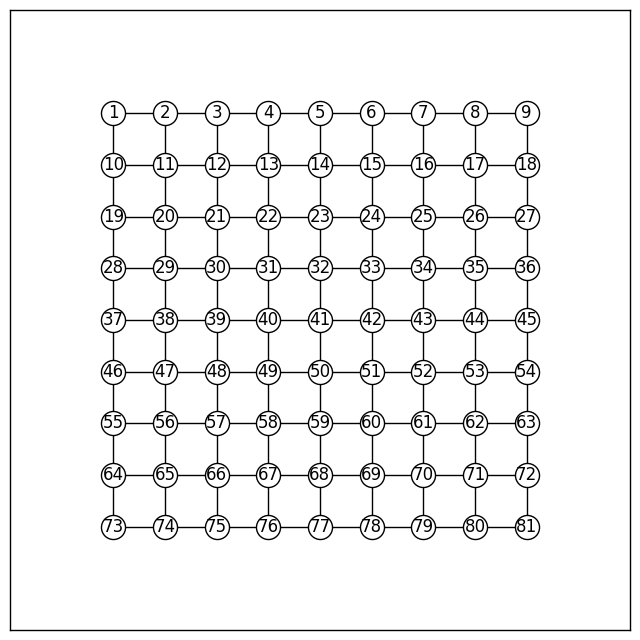

In [29]:
n = 8
grid_graph = GridGraph(n, n)
plt.figure(figsize=(n, n))
grid_graph.draw()

In [30]:
s, t = 1, (n + 1) * (n + 1)

In [31]:
GraphSet.set_universe(grid_graph.nx_graph.edges())

In [32]:
paths = GraphSet.paths(s, t).graph_size(n * 2)

In [33]:
min_hop_s_t = get_min_hop_num((s, t))

スリープするノードを選択（5パターン生成）

In [34]:
sleep_nodes_set = select_sleep_nodes_every_time(grid_graph, (s, t), 15, 5)

経路群を5本構築

In [35]:
candidates = create_candidate_paths(paths, sleep_nodes_set, (s, t))

経路群をJSONファイルに書き出す

In [36]:
dump_candidate_json(candidates)

JSONファイルの経路群を復元する

In [37]:
loaded_candidates = load_candidate_json("sleep15_candidate5_1.json")

経路群を描画する

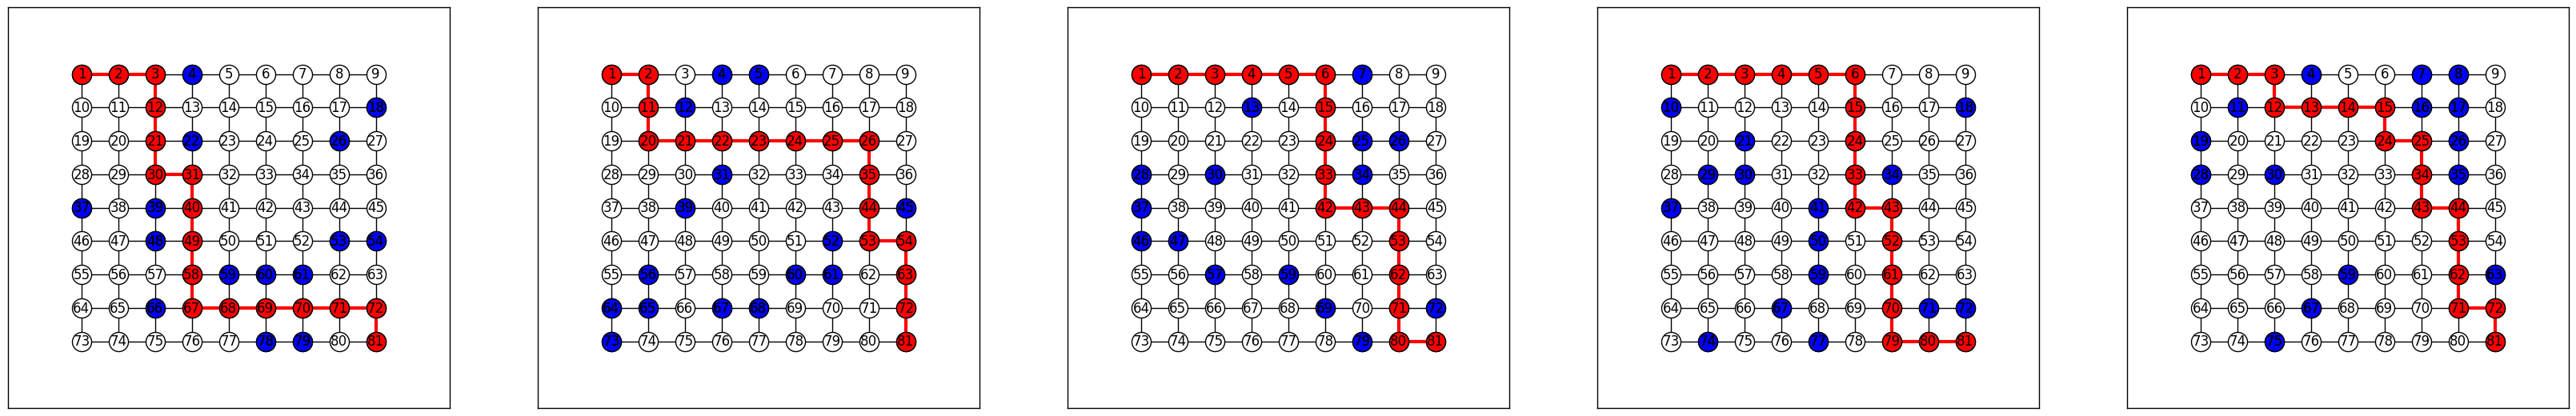

In [38]:
draw_candidates5(loaded_candidates)

まとめて描画

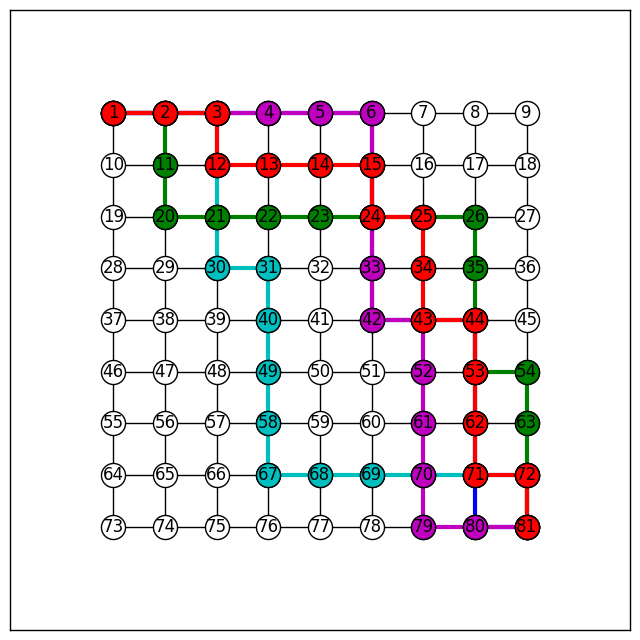

In [39]:
colors = ["c", "g", "b", "m", "r", "y"]
plt.figure(figsize=(n, n))
grid_graph.draw_multi_subgraphs(subgraphs=loaded_candidates.values(), colors=colors)

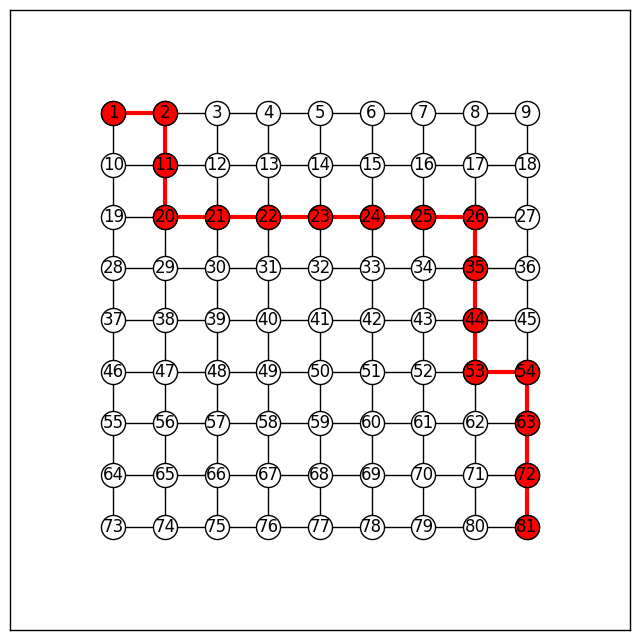

In [40]:
determinated, _ = hamming_between_candidates(loaded_candidates.values())
plt.figure(figsize=(n, n))
grid_graph.draw(subgraph=determinated)

経路群の各経路がもつ類似の代替経路（最小迂回で再構成できる経路）の本数

In [41]:
for path in list(loaded_candidates.values()):
    print(path, len(get_similar_paths(GraphSet.universe(), (s, t), path, 4).graph_size(min_hop_s_t)))

[(1, 2), (2, 3), (3, 12), (12, 21), (21, 30), (30, 31), (31, 40), (40, 49), (49, 58), (58, 67), (67, 68), (68, 69), (69, 70), (70, 71), (71, 72), (72, 81)] 6
[(1, 2), (2, 11), (11, 20), (20, 21), (21, 22), (22, 23), (23, 24), (24, 25), (25, 26), (26, 35), (35, 44), (44, 53), (53, 54), (54, 63), (63, 72), (72, 81)] 6
[(1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 15), (15, 24), (24, 33), (33, 42), (42, 43), (43, 44), (44, 53), (53, 62), (62, 71), (71, 80), (80, 81)] 5
[(1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 15), (15, 24), (24, 33), (33, 42), (42, 43), (43, 52), (52, 61), (61, 70), (70, 79), (79, 80), (80, 81)] 5
[(1, 2), (2, 3), (3, 12), (12, 13), (13, 14), (14, 15), (15, 24), (24, 25), (25, 34), (34, 43), (43, 44), (44, 53), (53, 62), (62, 71), (71, 72), (72, 81)] 10
